In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = r"C:\Users\ASUS\Documents\-em-bond-macro-analysis\data\Cleaned\panel_monthly_2010_2024_copy.csv"
df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['country','date']).reset_index(drop=True)


In [3]:
# numeric columns you used
numeric_cols = ['yield_10y','CPI_annual_pct','GDP_growth_annual_pct','External_debt_usd','usd_index','brent']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

countries = df['country'].unique().tolist()
print("Countries:", countries)

# 1) Quick counts & missing
print("\nObservations per country:")
print(df.groupby('country').size())

print("\nNull counts:")
print(df[numeric_cols].isna().sum())

Countries: ['Brazil', 'Egypt', 'India', 'South Africa', 'Sri Lanka', 'Turkey']

Observations per country:
country
Brazil          175
Egypt           172
India           168
South Africa    168
Sri Lanka       121
Turkey          179
dtype: int64

Null counts:
yield_10y                111
CPI_annual_pct             0
GDP_growth_annual_pct      0
External_debt_usd         37
usd_index                  3
brent                      3
dtype: int64


In [4]:
# 2) Stationarity (ADF) by country and variable (print p-values)
def adf_pval(series):
    series = series.dropna()
    if len(series) < 12:
        return np.nan
    try:
        return adfuller(series, maxlag=12, autolag='AIC')[1]
    except Exception:
        return np.nan

adf_results = []
for c in countries:
    temp = df[df['country']==c]
    for v in numeric_cols:
        adf_results.append({'country':c, 'var':v, 'adf_pval': adf_pval(temp[v])})
adf_df = pd.DataFrame(adf_results).pivot(index='country', columns='var', values='adf_pval')
print("\nADF p-values (if p < 0.05 likely stationary):")
print(adf_df)



ADF p-values (if p < 0.05 likely stationary):
var           CPI_annual_pct  External_debt_usd  GDP_growth_annual_pct  \
country                                                                  
Brazil              0.192227           0.274380               0.089952   
Egypt               0.532356           0.885577               0.157753   
India               0.217178           0.656169               0.276640   
South Africa        0.193131           0.359964               0.147539   
Sri Lanka           0.258473           0.708158               0.516526   
Turkey              0.807873           0.747411               0.136125   

var              brent  usd_index  yield_10y  
country                                       
Brazil        0.361320   0.665563   0.311769  
Egypt         0.368680   0.520154   0.753643  
India         0.378178   0.666394   0.419676  
South Africa  0.378178   0.666394   0.624809  
Sri Lanka     0.086526   0.078564        NaN  
Turkey        0.350818   0.6373

In [5]:
# 3) VIF on pooled sample (standardized) — to detect multicollinearity
# Drop rows with nan in numeric cols
vif_df = df[numeric_cols].dropna()
# standardize
X = (vif_df - vif_df.mean())/vif_df.std()
X['const'] = 1
vif_data = []
for i, col in enumerate(numeric_cols):
    vif_data.append({'var': col, 'VIF': variance_inflation_factor(X.values, i)})
vif_table = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
print("\nVIF (pooled sample):\n", vif_table)


VIF (pooled sample):
                      var       VIF
4              usd_index  1.907017
0              yield_10y  1.765395
5                  brent  1.721809
1         CPI_annual_pct  1.670716
3      External_debt_usd  1.308668
2  GDP_growth_annual_pct  1.118058


In [9]:
# 4)Lag correlations (0 to 6 months) for CPI and Brent for each country
maxlag = 6
lag_results = []
for c in countries:
    temp = df[df['country']==c].sort_values('date').reset_index(drop=True)
    for pair in [('CPI_annual_pct','yield_10y'), ('brent','yield_10y')]:
        corrs = []
        for lag in range(0, maxlag+1):
            s1 = temp[pair[0]].shift(lag)
            s2 = temp[pair[1]]
            r = s1.corr(s2)
            corrs.append(r)
        lag_results.append({'country':c, 'pair':pair[0]+'->'+pair[1], 'corrs':corrs})
# Print a compact table for lags 0..6
for r in lag_results:
    print(r['country'], r['pair'], ["{:.2f}".format(x) if pd.notna(x) else "NA" for x in r['corrs']])

Brazil CPI_annual_pct->yield_10y ['0.54', '0.57', '0.60', '0.61', '0.62', '0.62', '0.62']
Brazil brent->yield_10y ['0.21', '0.22', '0.23', '0.24', '0.24', '0.24', '0.25']
Egypt CPI_annual_pct->yield_10y ['0.78', '0.78', '0.77', '0.76', '0.75', '0.72', '0.70']
Egypt brent->yield_10y ['0.05', '0.06', '0.08', '0.09', '0.10', '0.11', '0.12']
India CPI_annual_pct->yield_10y ['0.50', '0.52', '0.53', '0.55', '0.56', '0.58', '0.60']
India brent->yield_10y ['0.67', '0.69', '0.70', '0.71', '0.71', '0.71', '0.72']
South Africa CPI_annual_pct->yield_10y ['0.12', '0.10', '0.08', '0.07', '0.06', '0.05', '0.04']
South Africa brent->yield_10y ['-0.32', '-0.31', '-0.33', '-0.34', '-0.37', '-0.38', '-0.38']
Sri Lanka CPI_annual_pct->yield_10y ['0.86', '0.51', '0.51', '0.51', '0.51', '0.51', '0.51']
Sri Lanka brent->yield_10y ['0.28', '0.56', '0.56', '0.50', '0.30', '0.29', '0.33']
Turkey CPI_annual_pct->yield_10y ['0.70', '0.67', '0.65', '0.61', '0.60', '0.57', '0.56']
Turkey brent->yield_10y ['-0.06', 

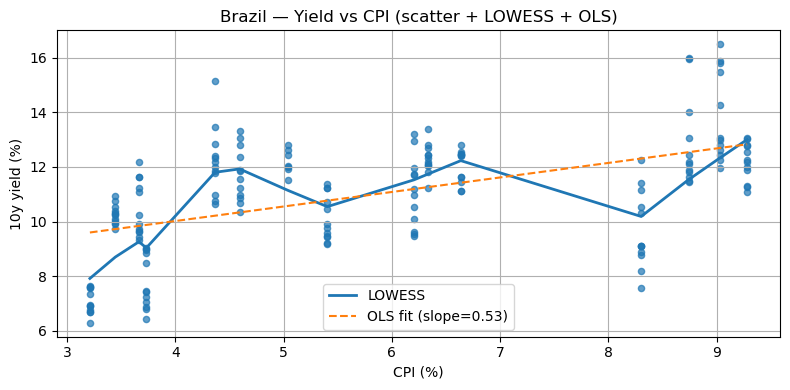

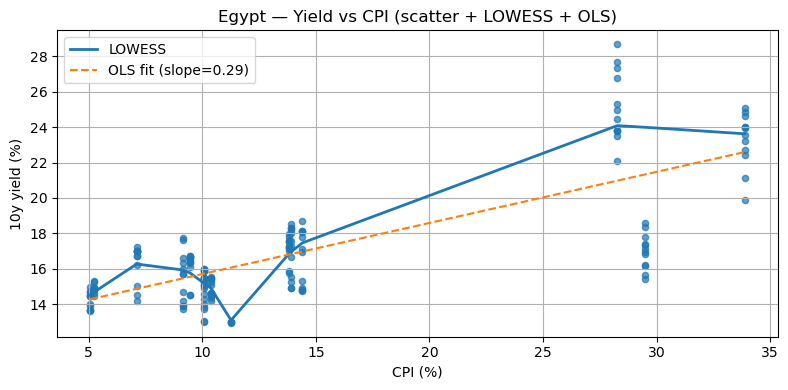

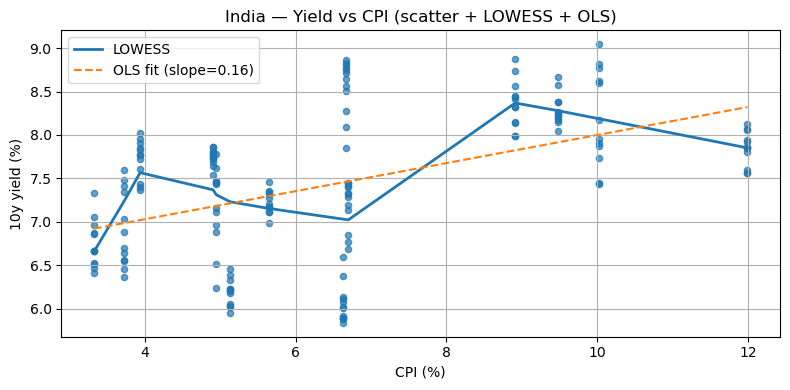

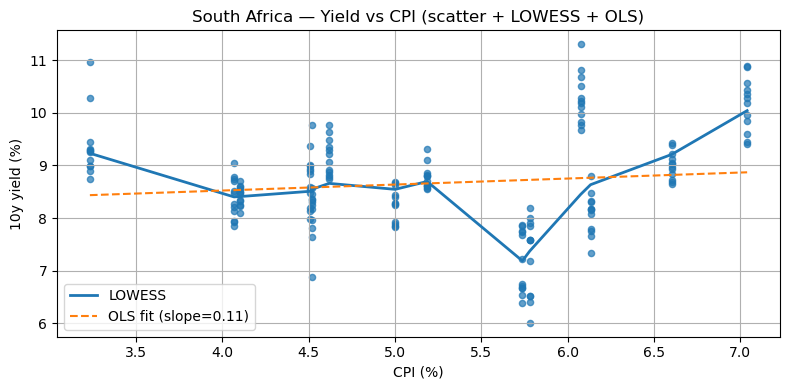

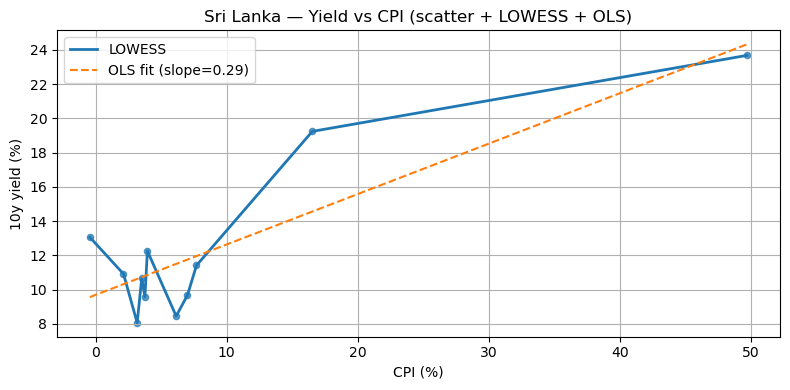

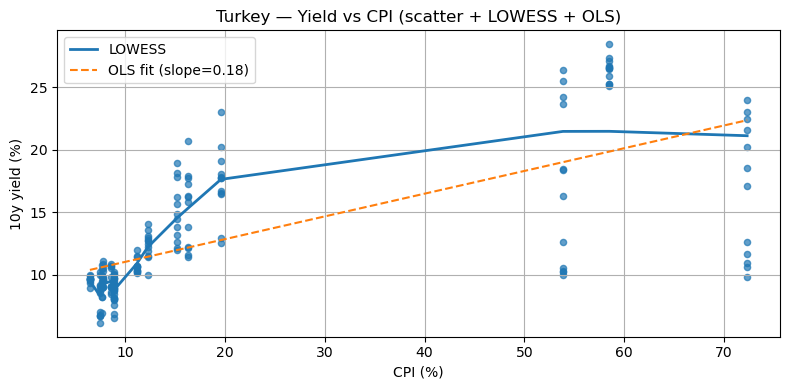

In [10]:
# 5) Scatter + LOWESS + OLS line example for CPI vs yield for each country (nice labeled plots)
for c in countries:
    temp = df[df['country']==c].dropna(subset=['yield_10y','CPI_annual_pct'])
    if len(temp) < 8:
        continue
    x = temp['CPI_annual_pct']; y = temp['yield_10y']
    # LOWESS
    smoothed = lowess(y, x, frac=0.3)
    # OLS fit
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    slope = model.params[1]; intercept = model.params[0]
    plt.figure(figsize=(8,4))
    plt.scatter(x, y, s=20, alpha=0.7)
    plt.plot(smoothed[:,0], smoothed[:,1], label='LOWESS', linewidth=2)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, intercept + slope*xs, label=f"OLS fit (slope={slope:.2f})", linestyle='--')
    plt.title(f"{c} — Yield vs CPI (scatter + LOWESS + OLS)")
    plt.xlabel('CPI (%)'); plt.ylabel('10y yield (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


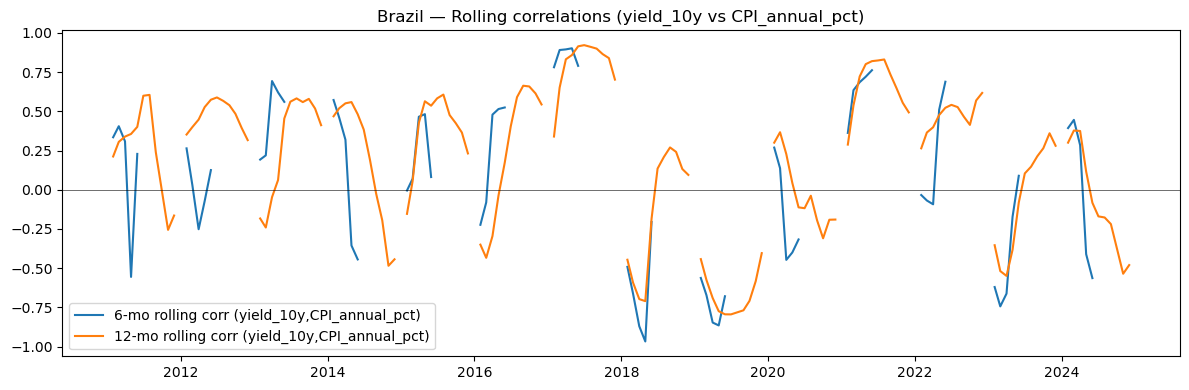

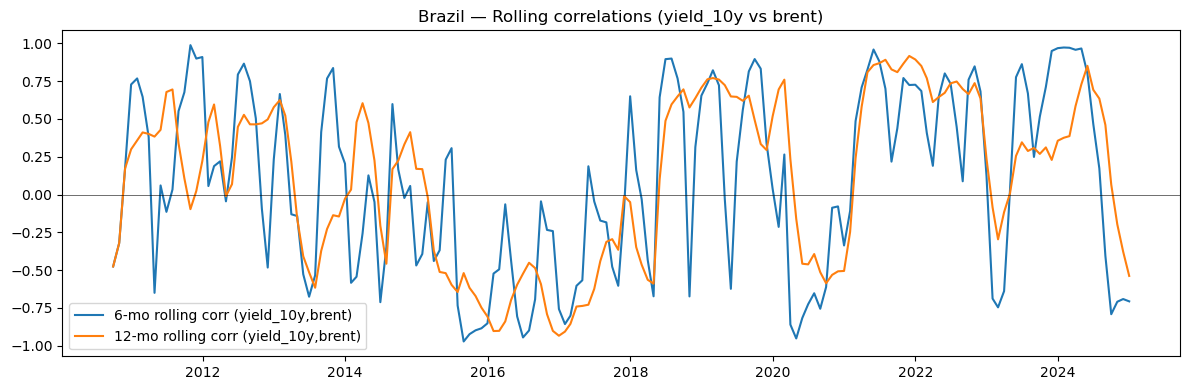

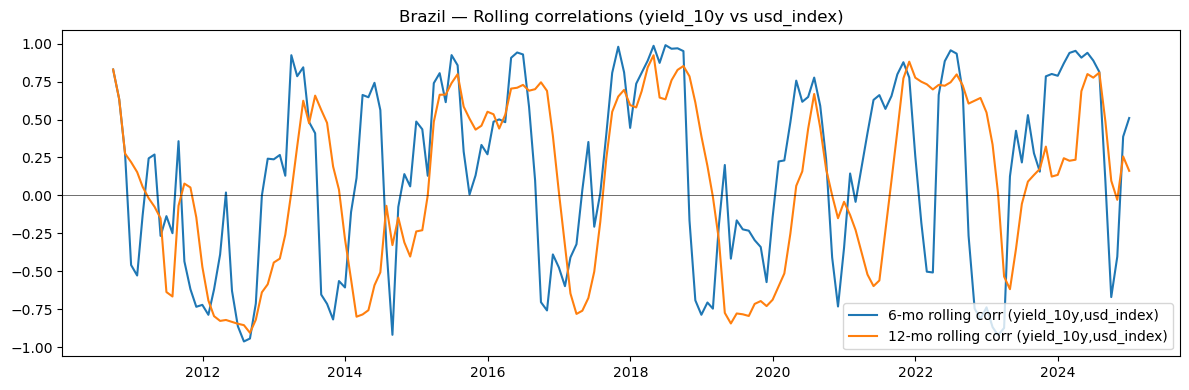

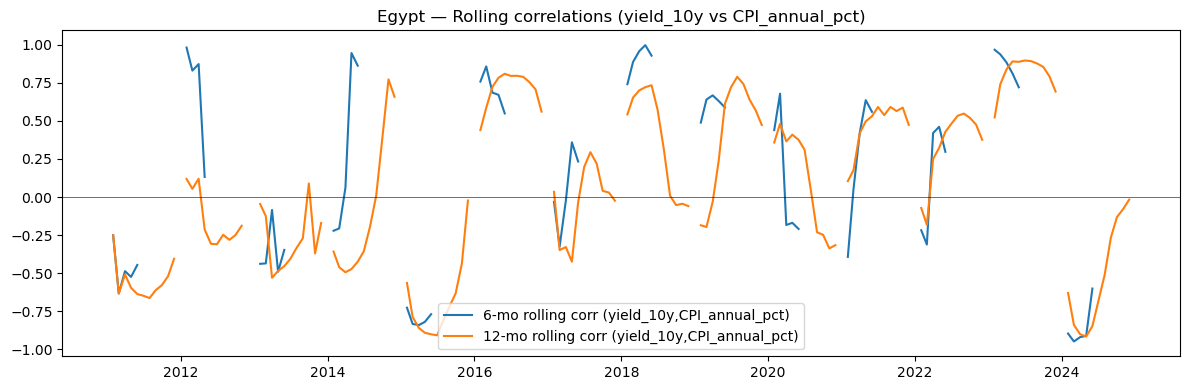

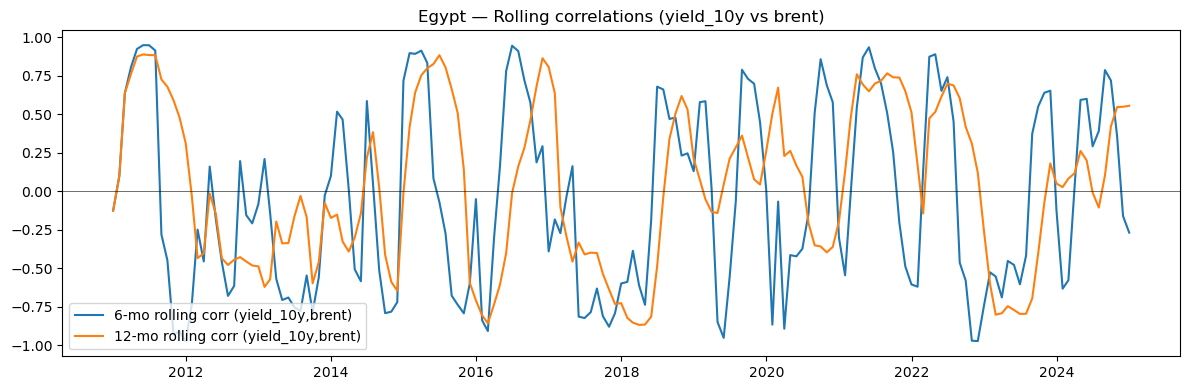

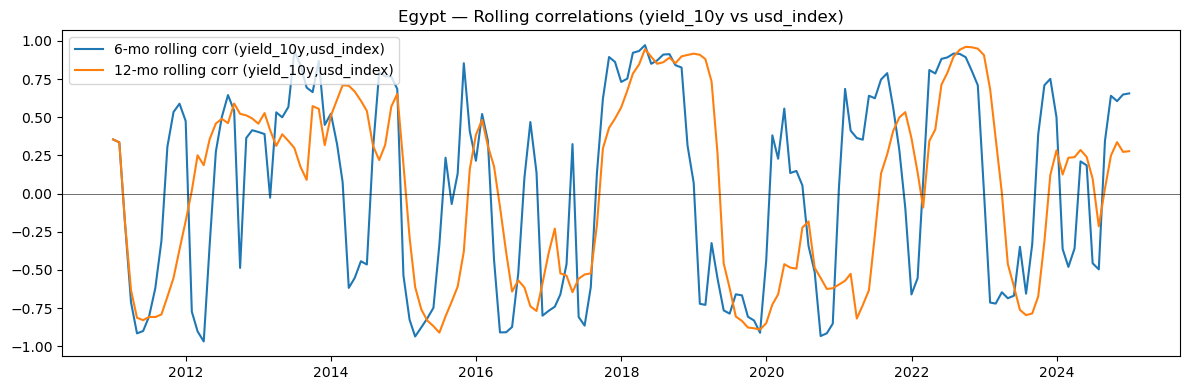

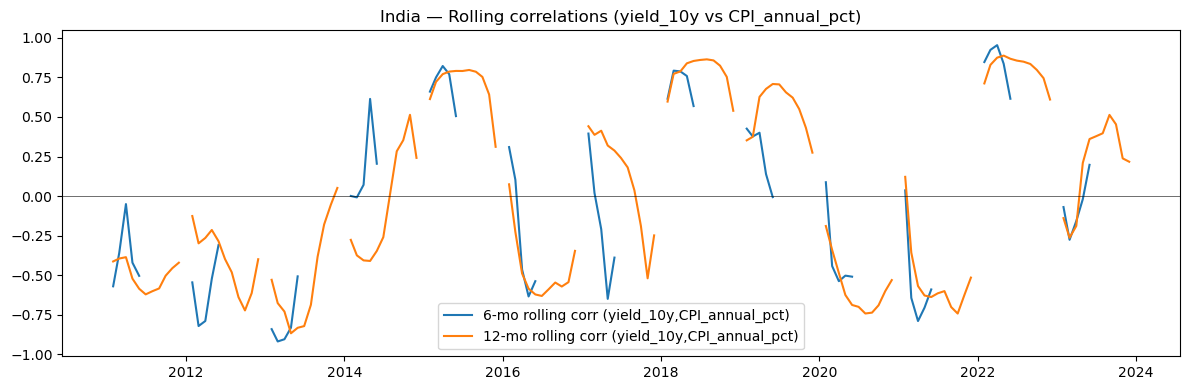

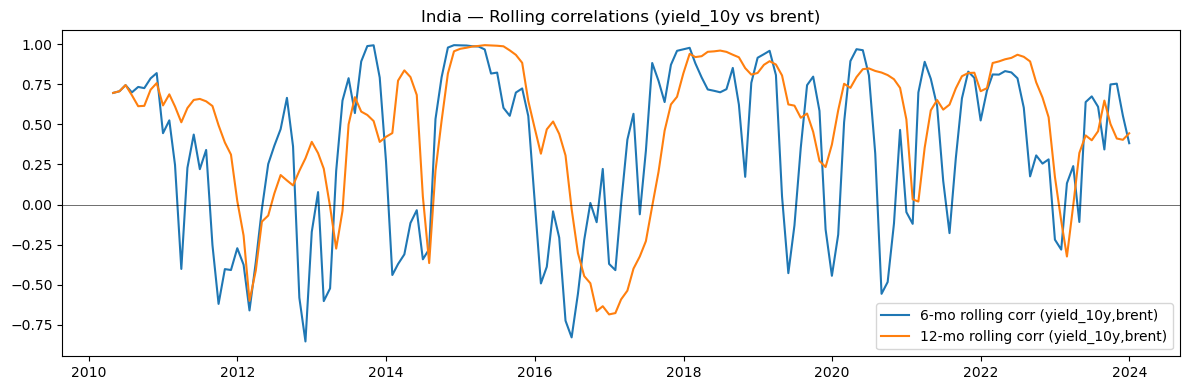

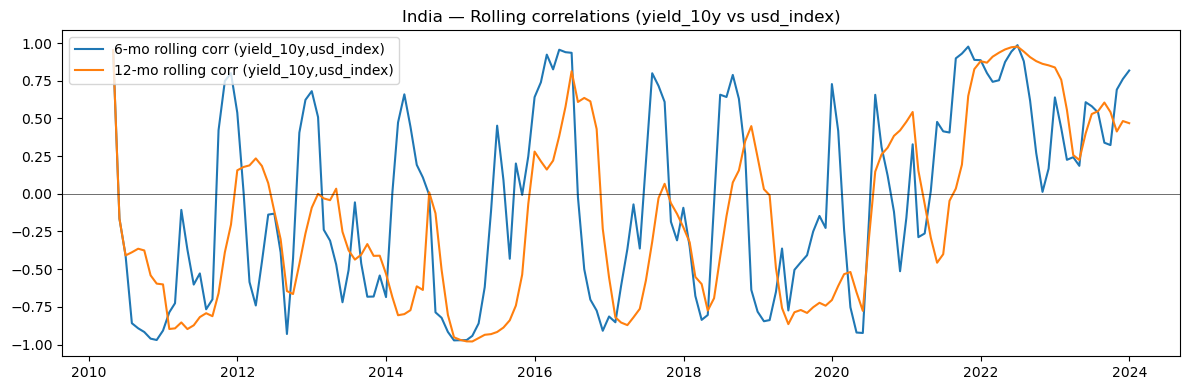

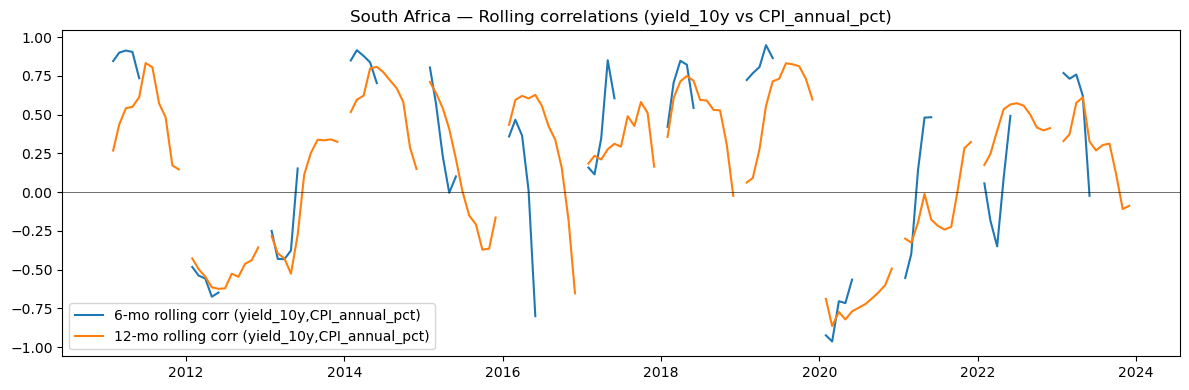

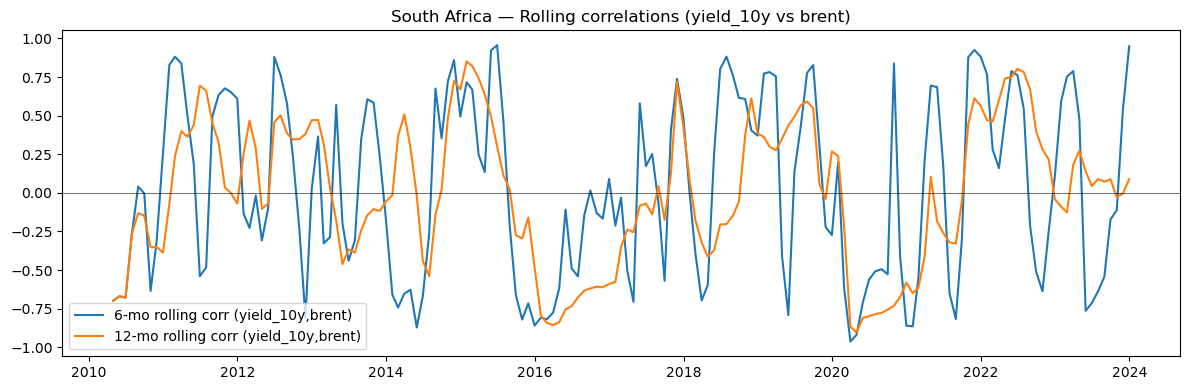

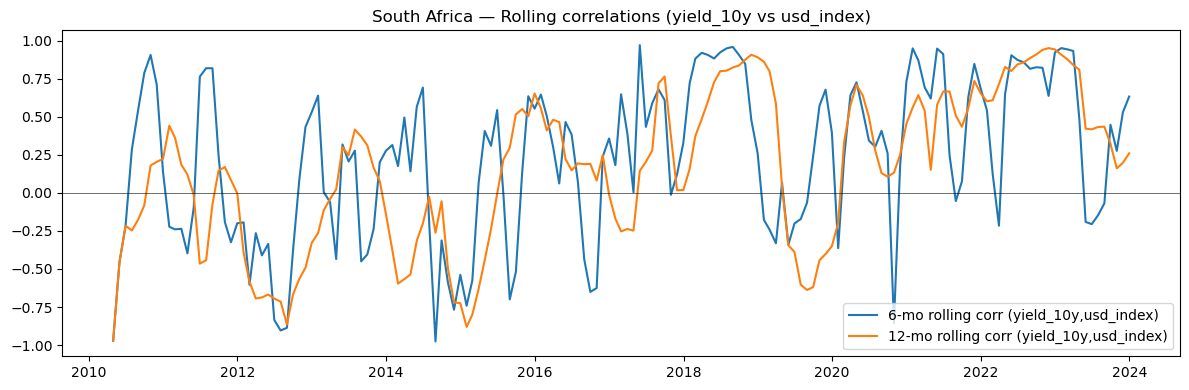

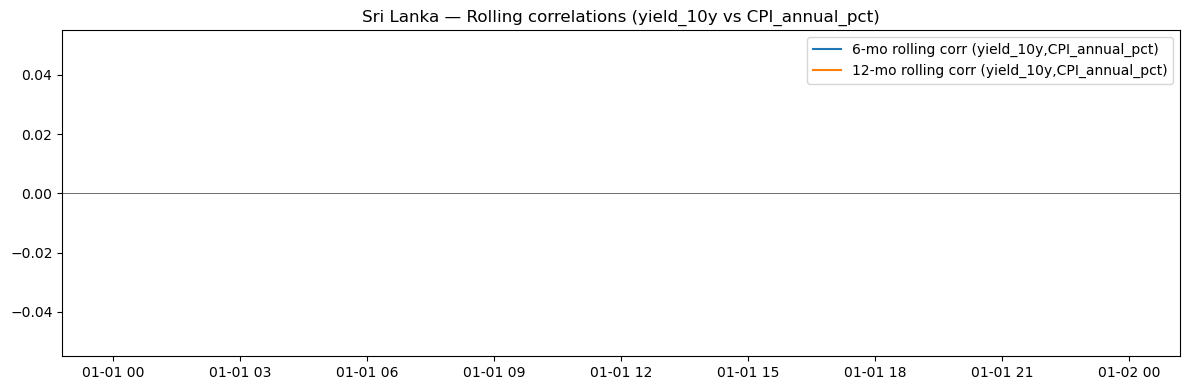

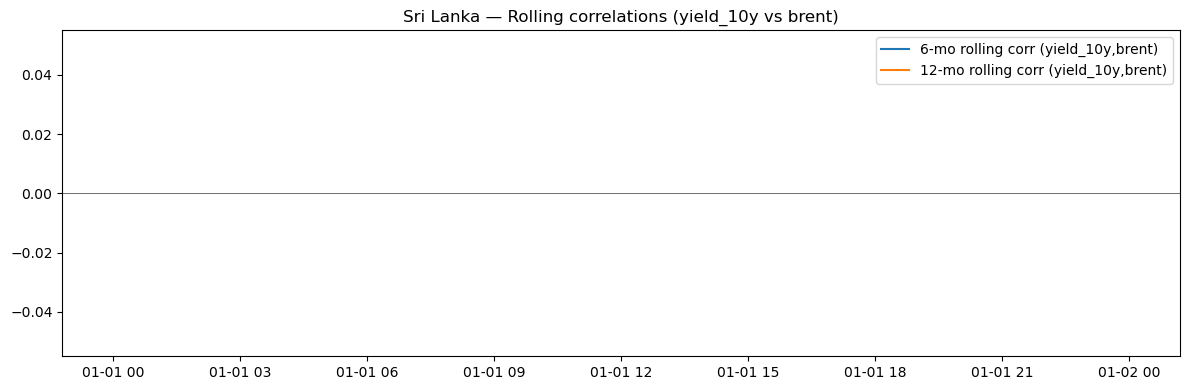

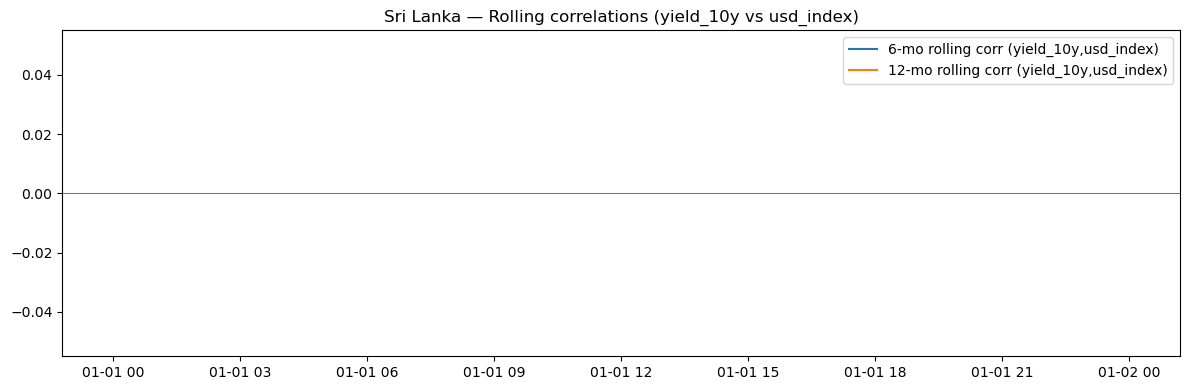

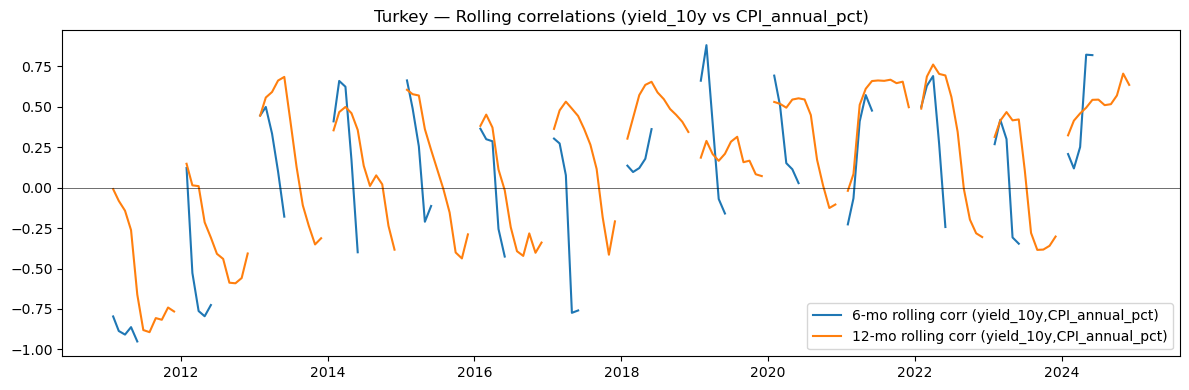

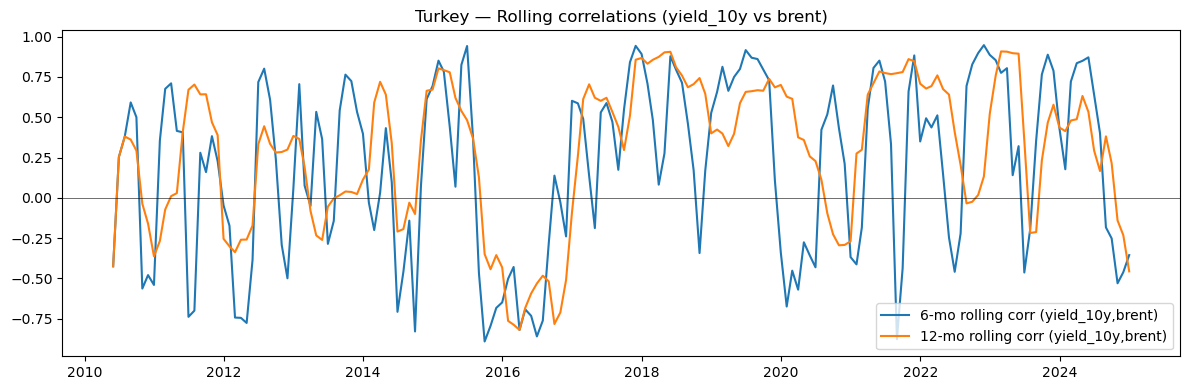

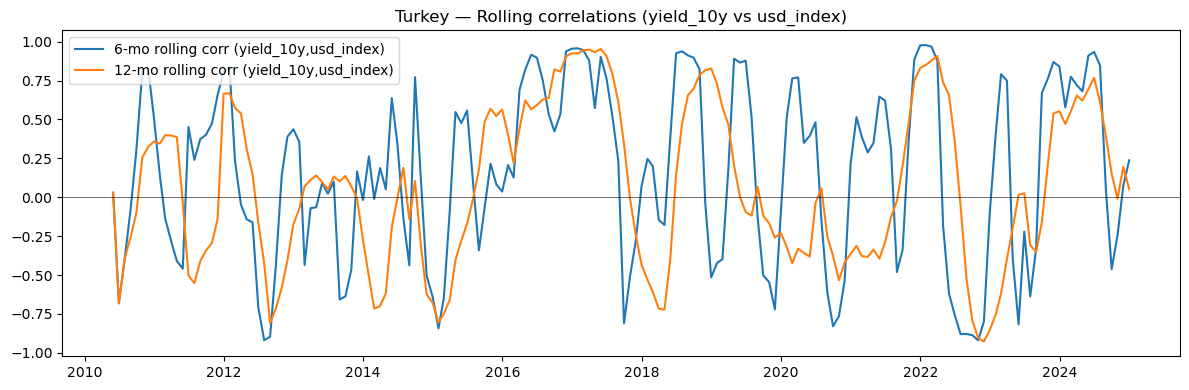

In [13]:
# 4) Rolling correlations (6 and 12 month) between yield and CPI, brent, USD per country — plots
window_list = [6, 12]
pairs = [
    ("yield_10y", "CPI_annual_pct"),
    ("yield_10y", "brent"),
    ("yield_10y", "usd_index")
]

for c in countries:
    temp = df[df['country'] == c].set_index('date').sort_index()
    if len(temp) < 12:
        continue
    
    for x, y in pairs:
        plt.figure(figsize=(12,4))
        for w in window_list:
            rc = temp[x].rolling(window=w, min_periods=4).corr(temp[y])
            plt.plot(rc.index, rc.values, label=f"{w}-mo rolling corr ({x},{y})")
        plt.title(f"{c} — Rolling correlations ({x} vs {y})")
        plt.axhline(0, color='k', linewidth=0.4)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [15]:
print(df_reg.dtypes)


date                     datetime64[ns]
country                          object
yield_10y                       float64
CPI_annual_pct                  float64
GDP_growth_annual_pct           float64
External_debt_usd               float64
usd_index                       float64
brent                           float64
dtype: object


In [16]:
# Drop rows with missing data in relevant columns
df_reg = df.dropna(subset=[
    'yield_10y','CPI_annual_pct','GDP_growth_annual_pct',
    'External_debt_usd','usd_index','brent'
]).copy()

# Create country dummies
country_dummies = pd.get_dummies(df_reg['country'], drop_first=True).astype(float)

# Define X and y
X = df_reg[['CPI_annual_pct','GDP_growth_annual_pct',
            'External_debt_usd','usd_index','brent']].astype(float)

X = sm.add_constant(pd.concat([X, country_dummies], axis=1))

y = df_reg['yield_10y'].astype(float)

# Run pooled OLS with robust SE
pooled = sm.OLS(y, X).fit(cov_type='HC1')
print("\nBaseline pooled OLS with country dummies (robust SE):")
print(pooled.summary())



Baseline pooled OLS with country dummies (robust SE):
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     392.6
Date:                Fri, 05 Sep 2025   Prob (F-statistic):          6.16e-291
Time:                        11:35:39   Log-Likelihood:                -1761.3
No. Observations:                 835   AIC:                             3545.
Df Residuals:                     824   BIC:                             3597.
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------